# Beijing Data Simulation

In [2]:
# !pip install ucimlrepo

In [1]:
import folium
import geopandas as gpd
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pyrosm
import osmnx as ox
import random
import csv
import pickle
import numpy as np
import math
import datetime as dt
from haversine import haversine, Unit
from shapely.geometry import Point, box
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo 
from pyproj import Transformer


tqdm.pandas()
path = r'C:\Users\nial\OneDrive\ETH Zürich\Statslab 2024\Beijing'
os.chdir(path)

### Load and investigate data

In [3]:
# dataframe 1: China Life
df_cl = pd.read_csv("China_Life.csv")

# dataframe 2: Longtan Park
df_lp = pd.read_csv("Longtan_Park.csv")

In [87]:
df_cl.head()

,lon,lat,pm25
0,116.4040,39.9131,38.786265
1,116.4043,39.9131,38.786265
2,116.4046,39.9131,38.786265
3,116.4048,39.9131,38.786265
4,116.4051,39.9131,38.786265


In [88]:
df_lp.head()

,lon,lat,pm25
0,116.4138,39.873,36.755009
1,116.4141,39.873,36.755009
2,116.4144,39.873,36.755009
3,116.4147,39.873,36.755009
4,116.4149,39.873,36.755009


### Compute hourly multipliers

We will combine the spatial data from Tsinghua University with temporal data from the US embassy in Beijing

In [72]:
df_temporal_usa = pd.read_csv("Beijing_PM2.5_2019_YTD.csv")

# filter to September
df_temporal_usa = df_temporal_usa[(df_temporal_usa['Month'] == 9)]

# have checked: there are no NAs in this & every hour should be covered

median_pm25 = np.median(df_temporal_usa['Raw Conc.'])
df_temporal_usa['Multiplier'] = df_temporal_usa['Raw Conc.'] / median_pm25
df_temporal_usa

In [75]:
df_temporal_usa.to_csv("df_temporal_usa.csv", index=False)

Plot diurnal profile

In [70]:
df_hourly_medians = df_temporal_usa.groupby(by='Hour')['Raw Conc.'].median().reset_index()
df_hourly_medians

,Hour,Raw Conc.
0,0,30.0
1,1,29.5
2,2,29.5
3,3,33.0
4,4,33.5
5,5,35.0
6,6,34.0
7,7,29.0
8,8,30.5
9,9,30.0


Load London data for comparison

In [211]:
df_london_median_values = pd.read_csv("df_london_median_values.csv")
df_london_median_values.head()

,Hour,Value
0,0,6.500
1,1,6.050
2,2,6.250
3,3,6.250
4,4,5.925


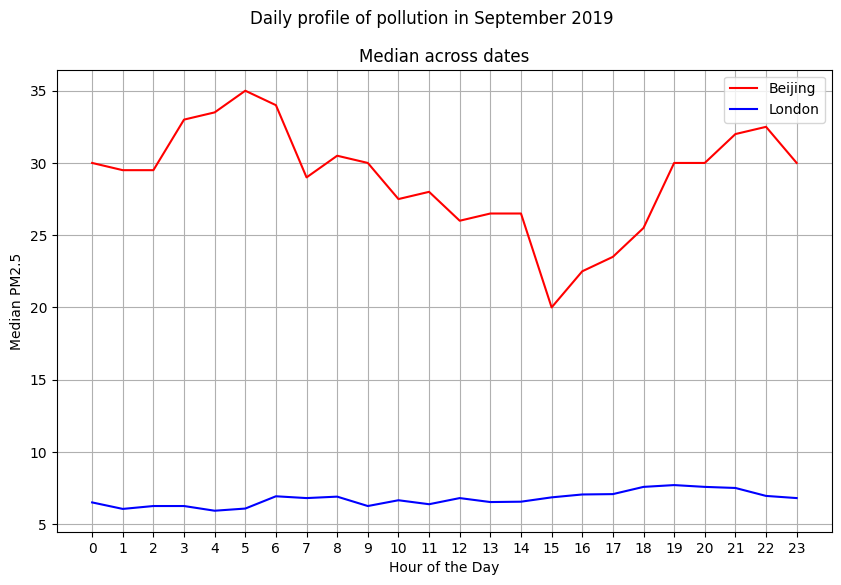

In [212]:
plt.figure(figsize=(10, 6))

plt.plot(df_hourly_medians['Hour'], df_hourly_medians['Raw Conc.'], color='red', label='Beijing')
plt.plot(df_london_median_values['Hour'], df_london_median_values['Value'], color='blue', label='London')

plt.xlabel('Hour of the Day')
plt.ylabel('Median PM2.5')
plt.suptitle('Daily profile of pollution in September 2019')
plt.title('Median across dates')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

### Get road network in both areas

In [5]:
def get_road_network(df: pd.DataFrame):
    """
    Extract the road network corresponding to the extent of a DataFrame within Beijing.

    INPUTS:
    df: with columns lat, lon; serves to define the bounding box (pd.DataFrame)

    OUTPUTS:
    nodes, edges: network from OSM for bounding box (gpd.GeoDataFrame)
    """
    min_lon = min(df['lon']) 
    min_lat = min(df['lat'])
    max_lon = max(df['lon'])
    max_lat = max(df['lat'])

    bbox = [min_lon, min_lat, max_lon, max_lat]
    pbf_path = "auto" # ?

    osm = pyrosm.OSM(pyrosm.get_data("Beijing"), bounding_box=bbox)

    # retrieve all highway types; we will manually filter to roads
    nodes, edges = osm.get_network(network_type="all", nodes=True)
    return nodes, edges

In [4]:
def get_G(df: pd.DataFrame, nodes: gpd.GeoDataFrame, edges: gpd.GeoDataFrame):
    """
    Combine road network into a graph object, G.

    INPUTS:
    df: dataframe defining spatial extent (pd.DataFrame)
    nodes: output [0] from get_road_network() (gpd.GeoDataFrame)
    edges: output [1] from get_road_network() (gpd.GeoDataFrame)
    
    OUTPUTS:
    G: graph comprising nodes and edges (networkx.MultiGraph)
    """
    # spatial extent
    min_lon = min(df['lon']) 
    min_lat = min(df['lat'])
    max_lon = max(df['lon'])
    max_lat = max(df['lat'])

    bbox = [min_lon, min_lat, max_lon, max_lat]
    pbf_path = "auto" # ?

    osm = pyrosm.OSM(pyrosm.get_data("Beijing"), bounding_box=bbox)

    # filter highways to just roads
    roads = ["primary", "unclassified", "residential", "road", "tertiary", "secondary", "primary_link", "secondary_link", "trunk", "trunk_link", "service"]
    edges = edges[edges["highway"].isin(roads)]

    # select columns to keep in nodes, edges
    ncols_to_keep = ["id","lon", "lat", "tags", "geometry"]
    ecols_to_keep = ["id", "tags","geometry", "u", "v", "length", "name", "highway"]

    nodes = nodes[ncols_to_keep]
    edges = edges[ecols_to_keep]

    # create G
    osm = pyrosm.OSM(pyrosm.get_data("Beijing"), bounding_box=bbox)
    G = osm.to_graph(nodes, edges, graph_type="networkx").to_undirected()

    return G
    

In [6]:
nodes_cl, edges_cl = get_road_network(df_cl)
nodes_lp, edges_lp = get_road_network(df_lp)

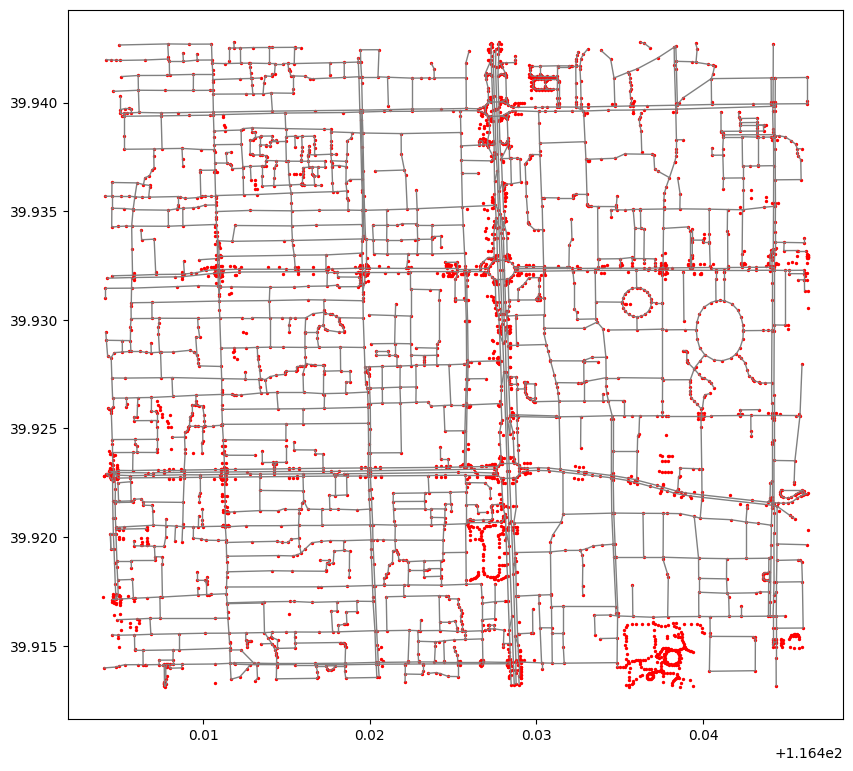

In [94]:
# plot China Life
ax = edges_cl.plot(figsize=(10,10), color="gray", lw=1.0)
ax = nodes_cl.plot(ax=ax, color="red", markersize=2)

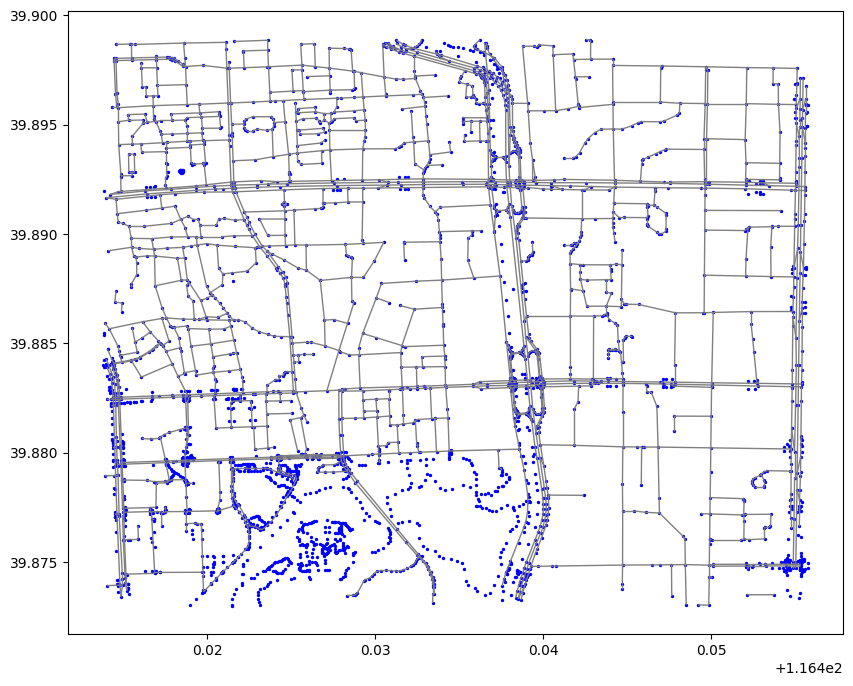

In [95]:
# plot Longtan Park
ax = edges_lp.plot(figsize=(10,10), color="gray", lw=1.0)
ax = nodes_lp.plot(ax=ax, color="blue", markersize=2)

In [105]:
# G_cl = get_G(df_cl, nodes_cl, edges_cl)
# G_lp = get_G(df_lp, nodes_lp, edges_lp)
# ox.plot_graph_folium(G_lp)
# ox.plot_graph_folium(G_cl)

# save graph objects
graph_path_cl = "G_cl.pkl"
with open(graph_path_cl, 'wb') as f:
   pickle.dump(G_cl,f)

graph_path_lp = "G_lp.pkl"
with open(graph_path_lp, 'wb') as f:
   pickle.dump(G_lp,f)

In [106]:
def simulate_trajectories(G, num_traj=100, plot=False):
    """
    input
    G: a networkx.classes.graph.Graph object
    num_traj: integer, # of trajectories to simulate
    plot: Boolean, whether to plot the simulated paths (to ensure coverage)
    Plotting is NOT recommended for n large (e.g., n>100)

    output
    trajectories: a list of simulated trajectories
    """
    n_sim = 0
    trajectories = list()
    node_list = list(G.nodes())

    while n_sim < num_traj:

        # pick distinct nodes at random
        origin = random.choice(node_list)
        destination = random.choice([n for n in node_list if n != origin])
        
        try:
            # compute shortest (distance) path
            metric_path = nx.dijkstra_path(G, source=origin, target=destination, weight='length')
        
            #save
            trajectories.append(metric_path)
            n_sim += 1

        except nx.NetworkXNoPath:
            print("No path between nodes")
            pass
    
    if plot:
        fig, ax = ox.plot_graph_routes(G, trajectories)

    return trajectories

Compute / save / re-load trajectories

In [15]:
# COMPUTE
# trajectories_cl = simulate_trajectories(G_cl, num_traj=10000,plot=False)
# trajectories_lp = simulate_trajectories(G_lp, num_traj=10000,plot=False)

# SAVE
outfile_cl = "trajectories_cl.csv"
outfile_lp = "trajectories_lp.csv"

# with open(outfile_cl, "w") as f:
#     wr = csv.writer(f)
#     wr.writerows(trajectories_cl)

# with open(outfile_lp, "w") as f:
#     wr = csv.writer(f)
#     wr.writerows(trajectories_lp)

# RELOAD
with open(outfile_cl, 'r') as file:
    csv_reader_cl = csv.reader(file) 
    list_of_csv_cl = list(csv_reader_cl) 

with open(outfile_lp, 'r') as file:
    csv_reader_lp = csv.reader(file) 
    list_of_csv_lp = list(csv_reader_lp) 

list_of_csv_cl = list_of_csv_cl[::2]
trajectories_cl = [[int(num) for num in row] for row in list_of_csv_cl]

list_of_csv_lp = list_of_csv_lp[::2]
trajectories_lp = [[int(num) for num in row] for row in list_of_csv_lp]

### Sampling Process

Now, we use the lists of trajectories in order to generate sample locations throughout the road network.

In [8]:
def coords_from_node(G, node_id):
    """
    Returns the (lat,lon) coordinates of a node in G 
    Input:
    G: graph
    node_id: node

    Output:
    coords: (lat,lon) tuple
    """
    lat = G.nodes[node_id]['y']
    lon = G.nodes[node_id]['x']

    return (lat,lon)

A function to retrieve the edge lengths along a single trajectory

In [9]:
def get_edge_lengths(trajectory, edges):
    """
    Retrieve edge lengths for a trajectory through G
    Input:
    trajectory: list of node IDs in G
    edges: geodf of edges in G

    Output:
    edge_lengths: df with edge, length, cum_length
    """
    t_edges = [(trajectory[i], trajectory[i+1]) for i in range(len(trajectory) - 1)]
    t_lengths = []

    # graph is bidirectional
    for u, v in t_edges:
        length = edges[(edges['u'] == u) & (edges['v'] == v)]['length'].values.tolist()
        if not length:
            length = edges[(edges['u'] == v) & (edges['v'] == u)]['length'].values.tolist()

        t_lengths.append(length[0])
    
    t_cum_lengths = np.cumsum(t_lengths)

    edge_df = pd.DataFrame(t_edges, columns=['u', 'v'])
    length_df = pd.DataFrame({'length':t_lengths, 'cumulative length':t_cum_lengths})

    edge_lengths = pd.concat([edge_df, length_df], axis=1)
    return edge_lengths

A function to determine the edges at which we sample and how far along them we sample

In [10]:
def get_edges_to_sample(edge_lengths):
    """
    Compute sequence of edges to sample, and how far along each we should sample
    Inputs:
    edge_lengths: output from get_edge_lengths()

    Outputs:
    edges_to_sample: df of edge to sample, distance along, cumulative distance, ...
    """
    traj_length = edge_lengths['cumulative length'].iloc[-1]
    num_samples = math.floor(traj_length / 8.33)

    # distances along path at which we will sample
    sample_dists = [round(i * 8.33,2) for i in range(1, num_samples + 1)]

    # identify edges corresponding to sample points
    bins = np.concatenate(([0], edge_lengths['cumulative length'].values))
    edge_indices = pd.cut(sample_dists, bins=bins, labels=False, include_lowest=True)

    # get length along edges of sample points
    length_along = [s - (edge_lengths['cumulative length'].iloc[edge_indices[i] - 1] if edge_indices[i]>0 else 0) for (i,s) in enumerate(sample_dists)]
    length_along = [round(l,2) for l in length_along]    

    # return
    edges_to_sample = pd.DataFrame({'Edge indices':edge_indices
                                    ,'Sample distance':sample_dists 
                                    ,'Distance along edge':length_along})
    
    edges_to_sample['u'] = edge_lengths.loc[edge_indices]['u'].values
    edges_to_sample['v'] = edge_lengths.loc[edge_indices]['v'].values
    edges_to_sample['length'] = edge_lengths.loc[edge_indices]['length'].values

    return edges_to_sample


In [11]:
def interpolate_nodes(nodes, node1, node2, distance_along, edge_length):
    """
    Compute point between two nodes.
    Inputs:
    nodes: df of graph nodes
    node1: ID of first node
    node2: ID of second node
    distance: # of meters from node1
    edge_length: total length of edge between nodes
    
    Outputs:
    inter_lat, inter_lon: coordinates of interpolated point
    """
    # check distance_along is valid
    frac = distance_along / edge_length
    if frac > 1.1 or frac < 0: raise ValueError("Invalid distance / edge length combination. \n \
                                              Frac: {}. Distance: {}. Edge length:{}".format(frac, distance_along, edge_length))

    n1_lat, n1_lon = nodes[nodes["id"] == node1]["lat"].iloc[0], nodes[nodes["id"] == node1]["lon"].iloc[0] 
    n2_lat, n2_lon = nodes[nodes["id"] == node2]["lat"].iloc[0], nodes[nodes["id"] == node2]["lon"].iloc[0] 

    inter_lat = n1_lat + (n2_lat - n1_lat)*frac
    inter_lon = n1_lon + (n2_lon - n1_lon)*frac

    return inter_lat, inter_lon

In [12]:
def coords_from_trajectory(trajectory, edges, nodes):
    """
    Convert a trajectory into a sequence of coords along it

    Inputs:
    trajectory: list of node IDs
    edges: edges DF for G
    nodes: nodes DF for G

    Outputs:
    coords: list of uniformly-spatially-spaced coordinate tuples
    """
    edge_lengths = get_edge_lengths(trajectory,edges)
    edges_to_sample = get_edges_to_sample(edge_lengths) 
    coords = edges_to_sample.apply(lambda row: interpolate_nodes(nodes, row['u'], row['v'], row['Distance along edge'], row['length']), axis=1).values.tolist()
    return coords

In [13]:
def coords_from_trajectories(trajectories, edges, nodes):
    """
    Convert a list of trajectories into a list of coordinate sequences

    Inputs:
    trajectories: output of simulate_trajectories()
    edges: G graph edges
    nodes: G graph nodes

    Outputs:
    coords: list of coordinate sequences
    """
    # all_coords = []
    # for i,t in enumerate(trajectories):
    #    try: coords = coords_from_trajectory(t, edges, nodes)
    #    except ValueError: print(f"Failed at trajectory {i}")
    #    all_coords.append(coords)

    return [coords_from_trajectory(t, edges, nodes) for t in trajectories]

In [16]:
coords_cl = coords_from_trajectories(trajectories_cl,edges_cl,nodes_cl)
coords_lp = coords_from_trajectories(trajectories_lp,edges_lp,nodes_lp)

Save `coords_cl` and `coords_lp`

In [17]:
coords_cl_file = "coords_cl.pkl"
coords_lp_file = "coords_lp.pkl"

with open(coords_cl_file, 'wb') as f:
    pickle.dump(coords_cl, f)

with open(coords_lp_file, 'wb') as f:
    pickle.dump(coords_lp, f)

Plot a random trajectory

In [28]:
i = np.random.randint(0, 10000)
random_traj = coords_cl[i]

random_traj = pd.DataFrame(random_traj, columns=['lat', 'lon'])

center_lat = random_traj['lat'].mean()
center_lon = random_traj['lon'].mean()

folium_map = folium.Map(location=[center_lat, center_lon], zoom_start=4)

for index, row in random_traj.iterrows():
    folium.Marker(location=[row['lat'], row['lon']]).add_to(folium_map)

folium_map

#### Temporal Dimension

We now have 10,000 trajectories for the drivers. Next, we will assign a random start time to each trajectory.

In [29]:
def get_random_time(start_time, end_time):
    """
    Returns a random time in a specified interval

    Inputs:
    start_time: start datetime
    end_time: end datetime

    Outputs: 
    random_time: random date_time
    """
    time_diff = end_time - start_time
    delta = random.random() * time_diff.total_seconds()

    random_time = start_time + dt.timedelta(seconds=delta)
    random_time = pd.to_datetime(random_time).round('1s')

    return random_time

In [30]:
def get_start_times(coords
                    , start_time=dt.datetime(2019, 9, 1, 0, 0, 0)
                    , end_time=dt.datetime(2019, 10, 1, 0, 0, 0)):
    """
    Assign a random start time in specified interval to each coord sequence

    Inputs:
    coords: list of coord sequences

    Outputs:
    start_times: list of random start times
    """
    start_times = [get_random_time(start_time, end_time) for c in coords]
    return start_times

In [ ]:
start_times_cl = get_start_times(coords_cl)
start_times_lp = get_start_times(coords_lp)

Now we have a function to get random start times. Next, we want to generate times for every coordinate measurement.

In [32]:
def get_all_times(coords, start_times):
    """
    Assign a datetime to every coord sampled.

    Input:
    coords: list of coordinate tuples
    start_times: list of start datetimes (at which measurement commenced)
    
    Output:
    all_times: dataframe of lat, lon, coordinate, time
    """
    tuples = []

    for i,c in enumerate(coords):
        start_time = start_times[i]
        for j, (lat, lon) in enumerate(c):
            time = start_time + dt.timedelta(seconds=j)
            tuples.append((lat, lon, time))
    
    all_times = pd.DataFrame(tuples, columns=['lat','lon','time'])
    return all_times

In [60]:
all_times_cl = get_all_times(coords_cl, start_times_cl)
all_times_lp = get_all_times(coords_lp, start_times_lp)

In [34]:
all_times_cl.head()

,lat,lon,time
0,39.923893,116.407098,2019-09-21 09:19:14
1,39.923894,116.407001,2019-09-21 09:19:15
2,39.923894,116.406903,2019-09-21 09:19:16
3,39.923894,116.406805,2019-09-21 09:19:17
4,39.923895,116.406708,2019-09-21 09:19:18


In [61]:
max(all_times_cl['time']), max(all_times_lp['time'])

(Timestamp('2019-09-30 23:30:39'), Timestamp('2019-09-30 23:52:35'))

Save / reload the all_times data

In [62]:
all_times_cl.to_csv("all_times_cl.csv")
all_times_lp.to_csv("all_times_lp.csv")

Final steps to take:

1) Clean the `hourly_multipliers` data for the sampling process
2) Define a function to sample pollution:
    * Note for identifying the closest point: we can still exploit the grid structure of the points

In [64]:
df_temporal_usa = pd.read_csv("df_temporal_usa.csv")

US Embassy sensors are less reliable than the London network. 2% of values are -999, and the smallest 15% or so look suspiciously low. We must for sure replace the negative values, e.g. with the median of values for that hour on different days. Worth noting is that `'NowCast Conc.'` also dips to -999.0 at some point. 

In [77]:
def patch_hourly_data(df_temporal_usa: pd.DataFrame):
    """
    Replace negative hourly values with the median of PM2.5 measurements at that hour across different days.

    INPUTS:
    df_temporal_usa: contains 'hour' column and 'Raw Conc.' (pd.DataFrame)

    OUTPUTS:
    df_temporal_usa: all negative values patched
    """
    # get hourly medians
    df_hourly_medians = df_temporal_usa.groupby(by='Hour')['Raw Conc.'].median().reset_index()

    # replace values where negative
    for index, row in df_temporal_usa.iterrows():
        if row['Raw Conc.'] < 0:
            df_temporal_usa.at[index, 'Raw Conc.'] = df_hourly_medians.at[row['Hour'], 'Raw Conc.']

    # recompute multipliers
    median_pm25 = np.median(df_temporal_usa['Raw Conc.'])
    df_temporal_usa['Multiplier'] = df_temporal_usa['Raw Conc.'] / median_pm25

    return df_temporal_usa

In [81]:
# df_temporal_usa = patch_hourly_data(df_temporal_usa)
df_temporal_usa.to_csv("df_temporal_usa.csv", index=False)

2) Define function for finding nearest grid point pre sampling

In [101]:
def get_grid_point_geo(df: pd.DataFrame, point: tuple):
    """
    Retrieve nearest grid point to a (lon, lat) point.
    
    Input:
    df: contains the grid points in 'lon' and 'lat' (pd.DataFrame)
    point: lon, lat (tuple)

    Output:
    grid_centroid: grid point nearest (lon, lat)
    """
    # unpack tuples
    lon, lat = point
 
    # find nearest grid point
    lon_nearest = df.iloc[(df['lon']-lon).abs().argsort()[:1]]['lon'].tolist()
    lat_nearest = df.iloc[(df['lat']-lat).abs().argsort()[:1]]['lat'].tolist()

    return *lon_nearest, *lat_nearest

Now we have everything we need to simulate the pollution values!

In [178]:
def simulate_pollution_row_geo(df, df_temporal_usa, row, sigma, alpha, beta, pgamma):
    """
    Simulate a PM2.5 measurement for a given row of all_times.

    Inputs:
    df: spatial PM2.5 profile (df_cl or df_lp)
    df_temporal_usa: US embassy data
    row: row from all_times dataframe
    sigma: Gaussian noise s.d.
    alpha: Gamma noise parameter
    beta: Gamma noise parameter
    pgamma: probability of injecting gamma noise

    Outputs:
    measurement: pm2.5 measurement
    """
    # fetch nearest centroid
    grid_lon, grid_lat = get_grid_point_geo(df=df, point=(row['lon'], row['lat']))

    # get base PM2.5 value
    base_pm25 = df['pm25'][(df['lon'] == grid_lon) & (df['lat'] == grid_lat)].values[0]
    base_pm25 = float(base_pm25)

    # fetch hourly multiplier
    rounded = row['time'].floor('h')
    date_part = rounded.date().strftime('%Y-%m-%d')
    day_part = rounded.day
    hour_part = rounded.hour
    multiplier = df_temporal_usa[(df_temporal_usa['Hour'] == hour_part) & (df_temporal_usa['Day'] == day_part)]['Multiplier']
    try: multiplier = multiplier.values[0]
    except IndexError: print(f"Multiplier: {multiplier}")
    
    # generate random noise
    gaussian = np.random.normal(loc=0,scale=sigma)
    uniform = np.random.uniform()

    # add Gamma noise with p=pgamma
    gamma = 0 if uniform >= pgamma else np.random.gamma(shape=alpha, scale=beta)

    # combine to get final PM2.5 value
    measurement = base_pm25 * multiplier + gaussian + gamma
    
    return measurement, (gamma > 0)

In [185]:
def simulate_pollution_geo(all_times, df, df_temporal_usa, sigma=1, alpha=5, beta=5, pgamma=0.05):
    """
    Simulate a PM2.5 measurement for every entry of all_times.

    Inputs:
    all_times: lon, lat, datetime combinations at which to simulate
    df: spatial PM2.5 profile (df_cl or df_lp)
    df_temporal_usa: US embassy data
    row: row from all_times dataframe
    sigma: Gaussian noise s.d.
    alpha: Gamma noise parameter
    beta: Gamma noise parameter
    pgamma: probability of injecting gamma noise

    Outputs:
    all_times: df with columns 'measurement' and 'gamma_noise' added
    """
    all_times[['measurement','gamma_noise']] = all_times.apply(lambda row:simulate_pollution_row_geo(df, df_temporal_usa, row, sigma, alpha, beta, pgamma), axis=1, result_type='expand')
    
    return all_times

In [124]:
atg_cl = simulate_pollution_geo(all_times_cl, df_cl, df_temporal_usa)
atg_cl.to_csv("atg_cl.csv")

atg_lp = simulate_pollution_geo(all_times_lp, df_lp, df_temporal_usa)
atg_lp.to_csv("atg_lp.csv")

### Now, we will preprocess the data for the GP pipeline

In [127]:
def process_for_gp_flow(df: pd.DataFrame):
    """
    Preprocess the dataframe of observations ahead of the Gaussian processes flow.

    Inputs:
    df: dataframe output of simulate_pollution_geo()

    Outputs:
    df: processed dataframe
    """
    # retain unique entries
    df.drop_duplicates(inplace=True)

    # rename columns
    df.rename({'measurement':'pm25'}, axis='columns', inplace=True)

    # filter to month of interest
    df = df[\
        (df['time'] >= '2019-09-01') &\
        (df['time'] < '2019-10-01')]
    
    # count active drivers
    df['count_drivers'] = df.groupby('time')['time'].transform('count')

    # filter out outliers
    df = df[df['pm25'] <= 500]

    # compute detrended PM2.5 values
    df = rolling_detrend(df)

    return df

In [128]:
def rolling_detrend(df: pd.DataFrame):
    """
    Compute PM2.5 baselines

    Input:
    df: dataframe in preprocessing sequence

    Output:
    df: dataframe with 15-minute, day and combined baselines
    """
    # compute baselines
    df_time = df.set_index('time')
    df_time.sort_index(inplace=True)
    df_time = df_time[['pm25']]
    df_time.drop_duplicates(inplace=True)
    baseline_15_min = df_time.rolling('15min').median()
    baseline_day = df_time.rolling('1D').median()

    # deduplicate times
    dupe_15_i = baseline_15_min.index.duplicated()
    dupe_day_i = baseline_day.index.duplicated()

    baseline_15_min = baseline_15_min[~dupe_15_i] 
    baseline_day = baseline_day[~dupe_day_i]

    # join data and baselines on time indices
    df = df.merge(baseline_15_min
                ,how='left'
                ,left_on='time'
                ,right_index=True
                ,suffixes=(None,'_baseline_15'))
    
    df = df.merge(baseline_day
                  , how='left'
                  , left_on='time'
                  , right_index=True
                  , suffixes=('_original','_baseline_day'))
    
    # subtract baselines from data
    df['pm25_detrended_15'] = df['pm25_original'] - df['pm25_baseline_15']
    df['pm25_detrended_day'] = df['pm25_original'] - df['pm25_baseline_day']
    df['pm25_detrended_comb'] = df['pm25_original'] - 0.5*\
        (df['pm25_baseline_15'] + df['pm25_baseline_day'])
    
    return df

In [129]:
atg_cl = process_for_gp_flow(atg_cl)

In [130]:
atg_cl.head()

,lat,lon,time,pm25_original,count_drivers,pm25_baseline_15,pm25_baseline_day,pm25_detrended_15,pm25_detrended_day,pm25_detrended_comb
0,39.923893,116.407098,2019-09-30 21:23:10,75.671748,2,74.887270,82.570200,0.784478,-6.898452,-3.056987
1,39.923894,116.407001,2019-09-30 21:23:11,75.039499,2,74.883226,82.570200,0.156273,-7.530700,-3.687214
2,39.923894,116.406903,2019-09-30 21:23:12,74.949495,2,74.879182,82.570129,0.070312,-7.620634,-3.775161
3,39.923894,116.406805,2019-09-30 21:23:13,75.462111,2,74.877853,82.570099,0.584258,-7.107988,-3.261865
4,39.923895,116.406708,2019-09-30 21:23:14,74.574007,2,74.876524,82.570099,-0.302517,-7.996092,-4.149304


In [131]:
atg_lp = process_for_gp_flow(atg_lp)

In [134]:
len(atg_lp)

2708622

### Compute tile ID

We also need to compute the `tile_id` of every point. `tile_id` is used to determine the probability than an observation is included in a subsample for one iteration of fitting the GP. I think it makes most sense to round each observation to the _nearest_ grid point - the same way we did when determining the spatial component of the PM2.5 `measurement`. Rather than, say, considering the grid points as the bottom left corners of tiles.

In [158]:
df_cl['lon']

0        116.4040
1        116.4043
2        116.4046
3        116.4048
4        116.4051
           ...   
17155    116.4452
17156    116.4455
17157    116.4457
17158    116.4460
17159    116.4463
Name: lon, Length: 17160, dtype: float64

In [159]:
def get_nearest_tile_ID(df: pd.DataFrame, point: tuple):
    """
    Retrieve ID of tile centroid nearest to a (lon, lat) point.
    
    INPUT:
    df: df_cl or df_lp (pd.DataFrame)
    point: (lon, lat)

    OUTPUT:
    ID: corresponds to observation in df closest to point (int)
    """
    # unpack tuples
    lon, lat = point
    
    # find nearest grid point
    lon_nearest = df.iloc[(df['lon']-lon).abs().argsort()[:1]]['lon'].tolist()
    lat_nearest = df.iloc[(df['lat']-lat).abs().argsort()[:1]]['lat'].tolist()

    lon_nearest, lat_nearest = *lon_nearest, *lat_nearest

    # get its ID
    tile_id = df[(df['lon'] == lon_nearest) & (df['lat'] == lat_nearest)].index.tolist()

    return tile_id[0]

In [172]:
atg_lp['tile_id'] = atg_lp.progress_apply(lambda row: get_nearest_tile_ID(df=df_lp, point=(row['lon'], row['lat'])), axis=1)
atg_cl['tile_id'] = atg_cl.progress_apply(lambda row: get_nearest_tile_ID(df=df_cl, point=(row['lon'], row['lat'])), axis=1)

100%|██████████| 2796649/2796649 [2:18:16<00:00, 337.08it/s]  


In [173]:
atg_lp.to_csv("atg_lp.csv")
atg_cl.to_csv("atg_cl.csv")

It's at this point that I realise that I did not keep track of the Gamma injections. Will re-compute the PM2.5 measurements while doing so... but sample locations (and thus tile IDs) will remain fixed. Pipeline:

1) recompute PM2.5 values
2) re-process the data (compute baselines, etc)

In [191]:
#1.) recompute PM2.5 data
atg_cl_gamma = simulate_pollution_geo(atg_cl, df_cl, df_temporal_usa)
atg_lp_gamma = simulate_pollution_geo(atg_lp, df_lp, df_temporal_usa)

atg_cl_gamma.to_csv("atg_cl_gamma.csv")
atg_lp_gamma.to_csv("atg_lp_gamma.csv")

In [196]:
atg_cl_gamma.columns

Index(['lat', 'lon', 'time', 'pm25_original', 'count_drivers',
       'pm25_baseline_15', 'pm25_baseline_day', 'pm25_detrended_15',
       'pm25_detrended_day', 'pm25_detrended_comb', 'tile_id', 'measurement',
       'gamma_noise'],
      dtype='object')

In [200]:
#1.5) prepreprocess

# drop all columns that will be created in preprocess()
# atg_cl_gamma.drop(columns=['pm25_original', 'pm25_baseline_15', 'pm25_baseline_day', 'pm25_detrended_15', 'pm25_detrended_day', 'pm25_detrended_comb', 'count_drivers'], inplace=True)
# atg_lp_gamma.drop(columns=['pm25_original', 'pm25_baseline_15', 'pm25_baseline_day', 'pm25_detrended_15', 'pm25_detrended_day', 'pm25_detrended_comb', 'count_drivers'], inplace=True)

#2) preprocess
atg_cl_gamma = process_for_gp_flow(atg_cl_gamma)
atg_lp_gamma = process_for_gp_flow(atg_lp_gamma)

Finally, we should introduce metric 'x', 'y' coordinates. We choose EPSG 32650, made for the band of longitude including Beijing.

In [4]:
atg_cl_gamma = pd.read_csv("atg_cl_gamma.csv")
atg_lp_gamma = pd.read_csv("atg_lp_gamma.csv")

# dataframe 1: China Life
df_cl = pd.read_csv("df_cl.csv")

# dataframe 2: Longtan Park
df_lp = pd.read_csv("df_lp.csv")

In [9]:
def transform_coords(lon, lat):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32650", always_xy=True)
    x, y = transformer.transform(lon, lat)
    return x, y

#df_lp[['x', 'y']] = df_lp.apply(
#    lambda row: pd.Series(transform_coords(row['lon'], row['lat']))
#    , axis=1
#)

#print("df_lp done!")

#df_cl[['x', 'y']] = df_cl.apply(
#    lambda row: pd.Series(transform_coords(row['lon'], row['lat']))
#    , axis=1
#)

#print("df_cl done!")



atg_cl_gamma[['x', 'y']] = atg_cl_gamma.apply(
    lambda row: pd.Series(transform_coords(row['lon'], row['lat']))
    , axis=1
)

print("atg_cl_gamma done!")

atg_lp_gamma[['x', 'y']] = atg_lp_gamma.apply(
    lambda row: pd.Series(transform_coords(row['lon'], row['lat']))
    , axis=1
)

print("atg_lp_gamma done!")

df_lp done!
df_cl done!


KeyboardInterrupt: 

In [10]:
df_lp.to_csv("df_lp.csv")
df_cl.to_csv("df_cl.csv")

In [ ]:
# save results (appended _OLD to previous versions)
atg_cl_gamma.to_csv("atg_cl_gamma.csv", index=False)
atg_lp_gamma.to_csv("atg_lp_gamma.csv", index=False)